In [1]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**FUNCTIONS USED IN THIS DATASET**

In [2]:

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def target_summary_with_cat(dataframe, target, categorical_col, cat_col_v2):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby([categorical_col, cat_col_v2])[target].mean(),
                        "TARGET_COUNT": dataframe.groupby([categorical_col, cat_col_v2])[target].count()}), end="\n\n\n")
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(20, 16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)
    
def high_correlated_cols(dataframe, corr_th=0.80):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    return drop_list

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
def hyperparameter_optimization(X, y):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, regressor, params in regressors:
        print(f"########## {name} ##########")
        rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=12, scoring="neg_mean_squared_error")))
        print(f"RMSE: {round(rmse, 6)} ({name}) ")

        gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)
        final_model = regressor.set_params(**gs_best.best_params_)
        rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=12, scoring="neg_mean_squared_error")))
        print(f"RMSE (After): {round(rmse, 6)} ({name}) ")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models


In [3]:
df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

overlook the data with basic commands:

In [4]:
print('SHAPE :\n')
print(df.shape ,'\n')
print('TYPES  :\n')
print(df.dtypes) 

SHAPE :

(1460, 81) 

TYPES  :

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF       

In [5]:
print('HEAD   :\n')
print(df.head(),'\n')
print('TAIL   :\n')
print(df.tail())
    

HEAD   :

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
1   2          20       RL       80.000     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story   
2   3          60       RL       68.000    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
3   4          70       RL       60.000     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story   
4   5          60       RL       84.000    14260   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl      NoRidge       Nor

let's overlook the data with describe:
the standart deviation of some variables like 'LotArea' and 'GrLivArea' are high.Which means there are less reliable
SalePrice is excluded as it's our target variable 
From count, the missing values of numerical variables can be seen

In [6]:
print('DESCRIBE   :\n')
print(df.describe().T)

DESCRIBE   :

                 count       mean       std       min        25%        50%        75%        max
Id            1460.000    730.500   421.610     1.000    365.750    730.500   1095.250   1460.000
MSSubClass    1460.000     56.897    42.301    20.000     20.000     50.000     70.000    190.000
LotFrontage   1201.000     70.050    24.285    21.000     59.000     69.000     80.000    313.000
LotArea       1460.000  10516.828  9981.265  1300.000   7553.500   9478.500  11601.500 215245.000
OverallQual   1460.000      6.099     1.383     1.000      5.000      6.000      7.000     10.000
OverallCond   1460.000      5.575     1.113     1.000      5.000      5.000      6.000      9.000
YearBuilt     1460.000   1971.268    30.203  1872.000   1954.000   1973.000   2000.000   2010.000
YearRemodAdd  1460.000   1984.866    20.645  1950.000   1967.000   1994.000   2004.000   2010.000
MasVnrArea    1452.000    103.685   181.066     0.000      0.000      0.000    166.000   1600.000
BsmtFi

detecting missing values
1)check if there are any 
2)deal with them as categorical and numerical separately to decide how to manipulate

In [7]:
print('NA   :\n')
print(df.isnull().sum())

NA   :

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
Lo

to see all the missing values

the ones with a high ratio of missing values should be eliminated.

In [8]:
missing_values_table(df)

              n_miss  ratio
PoolQC          1453 99.520
MiscFeature     1406 96.300
Alley           1369 93.770
Fence           1179 80.750
FireplaceQu      690 47.260
LotFrontage      259 17.740
GarageType        81  5.550
GarageYrBlt       81  5.550
GarageFinish      81  5.550
GarageQual        81  5.550
GarageCond        81  5.550
BsmtExposure      38  2.600
BsmtFinType2      38  2.600
BsmtFinType1      37  2.530
BsmtCond          37  2.530
BsmtQual          37  2.530
MasVnrArea         8  0.550
MasVnrType         8  0.550
Electrical         1  0.070


there are 1460 rows in total.It'll make sense to drop the PoolQC,MiscFeature,Alley,FireplaceQu and Fence columns which have quite a few null rows and the 'Id' column as it won't help us examine or eliminate the data                

In [9]:
df.drop(["PoolQC","MiscFeature","Alley","Fence","FireplaceQu","LotFrontage"],inplace=True, axis=1)
df.drop("Id",inplace=True, axis=1)


let's fill the empty values of the numerical variables with their mean

In [10]:
df = df.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)

after dealing with numerical variables, now fill the rest with the word "unknown" and check the null values again

In [11]:
df = df.fillna("Unknown")

In [12]:
df.isnull().values.any()

False

two columns OverallQual and OverallCond give us an overall rate from 1 to 10. They can be merged as one column to examine together by taking their median. The columns can be dropped afterwards 

In [13]:
df["Overall"] = df.groupby("OverallQual")["OverallCond"].transform("median")

In [14]:
df["Overall"].unique()

array([5., 6., 4., 2., 3.])

In [15]:
df=df.drop(["OverallQual","OverallCond"], axis=1)

again,two related variables about roof can be observed together 

In [16]:
df["Roof"] = df[['RoofStyle', 'RoofMatl']].agg('-'.join, axis=1)

In [17]:
df["Roof"].head()

0    Gable-CompShg
1    Gable-CompShg
2    Gable-CompShg
3    Gable-CompShg
4    Gable-CompShg
Name: Roof, dtype: object

In [18]:
df=df.drop(["RoofStyle","RoofMatl"], axis=1)

categorizing columns(numerical, categorical and recategorized values)

In [19]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 1460
Variables: 72
cat_cols: 47
num_cols: 24
cat_but_car: 1
num_but_cat: 11


In [20]:
cat_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'Roof',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'YrSold',
 'Overall']

The target value "SalePrice" can be compared with similar various variables as seen below

In [21]:
target_summary_with_cat(df, "SalePrice", 'SaleCondition','SaleType')

                        TARGET_MEAN  TARGET_COUNT
SaleCondition SaleType                           
Abnorml       COD        145345.833            24
              CWD        328900.000             1
              ConLD       82450.000             2
              ConLI      125000.000             1
              Oth        119850.000             3
              WD         147607.700            70
AdjLand       WD         104125.000             4
Alloca        WD         167377.417            12
Family        CWD        136000.000             1
              WD         150315.789            19
Normal        COD        142239.474            19
              CWD        188750.000             2
              Con        269600.000             2
              ConLD      141500.000             6
              ConLI      219237.500             4
              ConLw      143700.000             5
              WD         175714.275          1160
Partial       ConLD      235128.000             1


In [22]:
target_summary_with_cat(df, "SalePrice", 'BldgType','ExterCond')

                    TARGET_MEAN  TARGET_COUNT
BldgType ExterCond                           
1Fam     Ex          201333.333             3
         Fa           98065.000            20
         Gd          169764.778           135
         Po           76500.000             1
         TA          189511.593          1061
2fmCon   Fa          113200.000             7
         Gd          145166.667             3
         TA          131119.048            21
Duplex   Fa          118964.000             1
         Gd          162400.000             2
         TA          132660.653            49
Twnhs    Gd          106000.000             3
         TA          138155.000            40
TwnhsE   Gd          220833.333             3
         TA          180908.694           111




correlation matrix gives us the most correlated values which are the darkest blue ones in the plot 

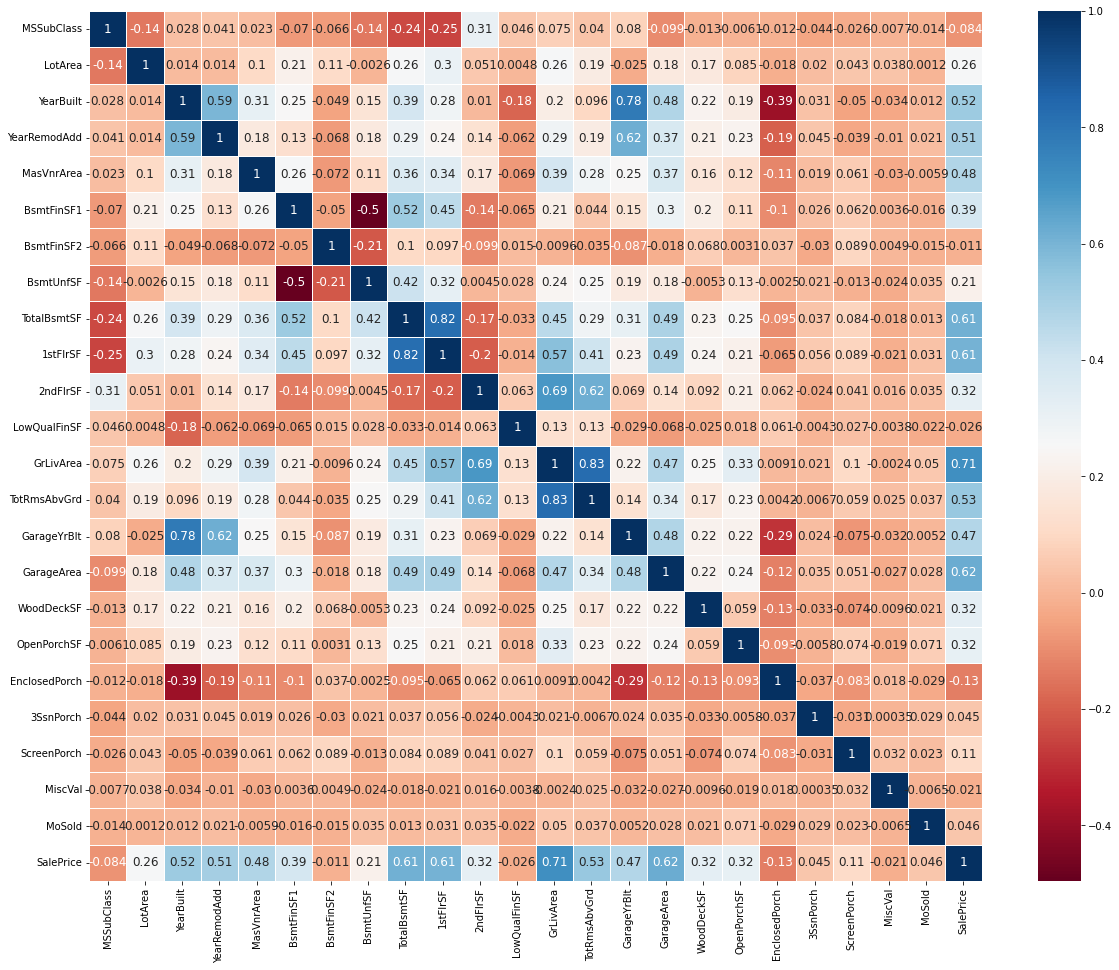

In [23]:
correlation_matrix(df, num_cols)


 '1stFlrSF', 'GrLivArea', 'GarageArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.Strong correlations among features is not something we want, because it slightly prevents us getting information about the features that contributing more to the prediction. Therefore, we are dropping more than %80 percent coreelated columns

In [24]:
drop_list = high_correlated_cols(df)

In [25]:
drop_list

['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']

In [26]:
df= df.drop(drop_list, axis=1)

let's plot the target variable 'SalePrice'. As seen below;the majority of the house prices are between 100000 - 300000. If we label this part as affordable and convert the column to categorical var. , we can run ml algorithm on it  

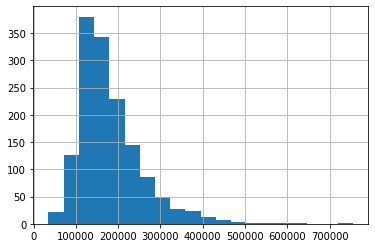

In [27]:
df['SalePrice'].hist(bins=20)
plt.show()

In [28]:

df['SalePrice'] = df['SalePrice'].astype(float)
df['SalePrice'].dtypes

dtype('float64')

let's call the function to recategorize the columns 

In [29]:
cat_cols,num_cols,cat_but_car = grab_col_names(df)

Observations: 1460
Variables: 69
cat_cols: 47
num_cols: 21
cat_but_car: 1
num_but_cat: 11


OUTLIERS!!! Now its time to check the outliers of the numerical columns.Seaborn's boxplot is used to visualize the outliers.

MSSubClass False
LotArea True
YearBuilt True
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
GarageYrBlt False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
MiscVal True
MoSold False
SalePrice True


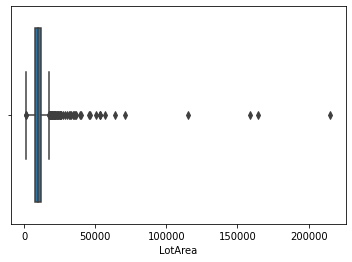

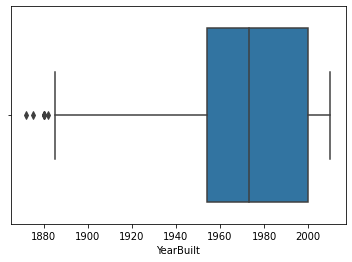

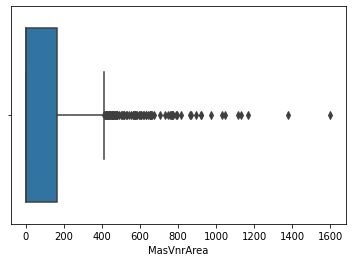

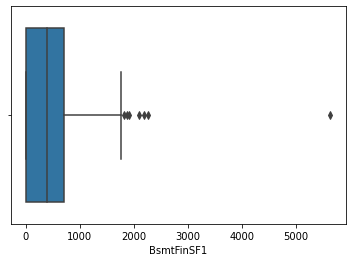

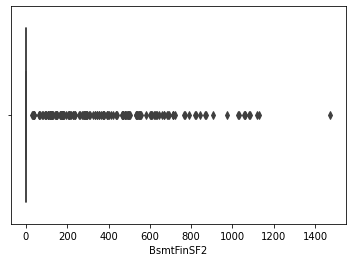

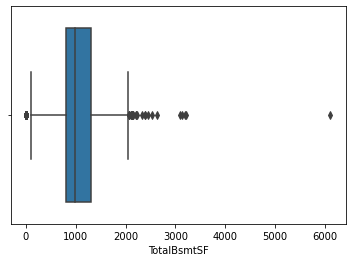

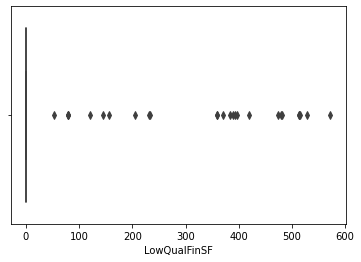

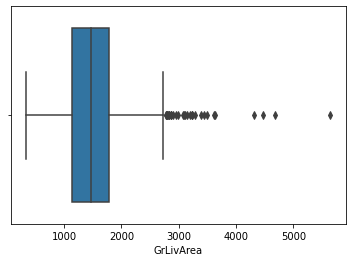

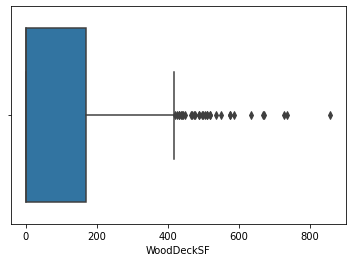

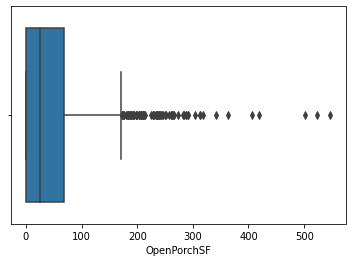

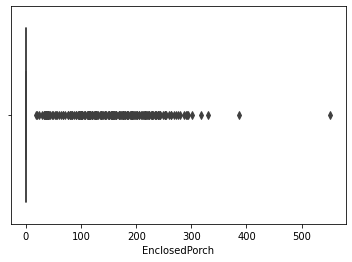

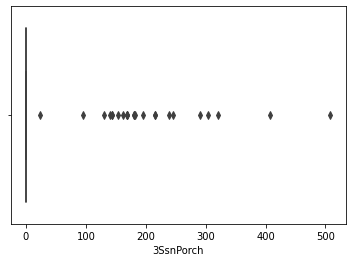

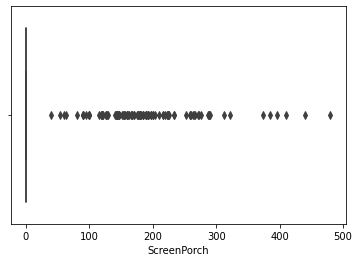

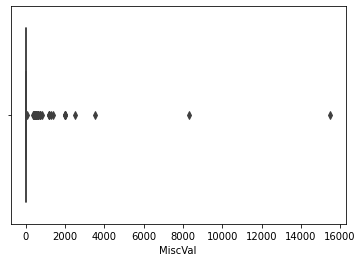

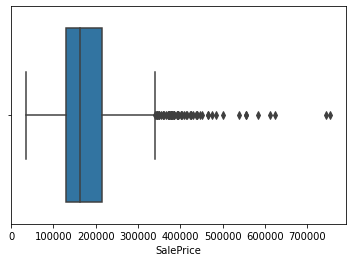

In [30]:
for col in num_cols:
    print(col, check_outlier(df, col))


for i in num_cols:
    if check_outlier(df,i) is True:
        sns.boxplot(x=df[i])
        plt.show()

In [31]:
df.isnull().values.any()

False

The threshold is %15-%95 . The rest is replaced with the upper or lower threshold to get rid of outliers 

In [32]:
for col in num_cols:
    replace_with_thresholds(df, col)


In [33]:
for col in num_cols:
    print(col, check_outlier(df, col))

MSSubClass False
LotArea False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
GarageYrBlt False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
MiscVal False
MoSold False
SalePrice False


let's run one hot encoder function on categorical columns.'Neighborhood' column is too unique to encode,so droping it would be a better solution

In [34]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [35]:
df['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [36]:
df.drop("Neighborhood",inplace=True, axis=1)


after handling categorical columns with encoder, not its time to scale all the numerical columns left

In [37]:
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [38]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

Observations: 1460
Variables: 250
cat_cols: 232
num_cols: 18
cat_but_car: 0
num_but_cat: 232


In [39]:
df.head()

,MSSubClass,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unknown,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unknown,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unknown,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unknown,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType1_Unknown,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFinType2_Unknown,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Electrical_Unknown,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_Unknown,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Unknown,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageQual_Unknown,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,GarageCond_Unknown,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Roof_Flat-Membran,Roof_Flat-Metal,Roof_Flat-Tar&Grv,Roof_Gable-CompShg,Roof_Gable-Roll,Roof_Gable-Tar&Grv,Roof_Gable-WdShngl,Roof_Gambrel-CompShg,Roof_Hip-ClyTile,Roof_Hip-CompShg,Roof_Hip-WdShake,Roof_Hip-WdShngl,Roof_Mansard-CompShg,Roof_Mansard-WdShake,Roof_Shed-CompShg,Roof_Shed-WdShake,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,BsmtHalfBath_1,BsmtHalfBath_2,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,PoolArea_480,PoolArea_512,PoolArea_519,PoolArea_555,PoolArea_576,PoolArea_648,PoolArea_738,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Overall_3.0,Overall_4.0,Overall_5.0,Overall_6.0
0,0.073,-0.327,1.051,0.879,0.524,0.599,-0.294,-0.945,-0.473,1.162,0.000,0.377,1.021,-0.753,0.223,-0.361,0.000,-0.272,0.000,-1

In [40]:
y_train = df['SalePrice']
X_train = df.drop(['SalePrice'],axis=1)

choosing the best classifier is importing. In this case, lightGBM has the highest rate

In [41]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}


lgbm_params = {"learning_rate": [0.01, 0.02, 0.03, 0.1, 0.001],
               "n_estimators": [100, 250, 300, 350, 500, 1000],
               "colsample_bytree": [0.5, 0.8, 0.7, 0.6, 1]}

regressors = [('KNN', KNeighborsRegressor(),knn_params),
              ('CART', DecisionTreeRegressor(),cart_params),
              ('RF', RandomForestRegressor(),rf_params),
              ('GBM', GradientBoostingRegressor(),gbm_params),
              ("XGBoost", XGBRegressor(objective='reg:squarederror'),xgboost_params),
              ("LightGBM", LGBMRegressor(),lgbm_params),
              ]

In [42]:
best_models = hyperparameter_optimization(X_train, y_train)

Hyperparameter Optimization....
########## KNN ##########
RMSE: 0.458456 (KNN) 
RMSE (After): 0.458782 (KNN) 
KNN best params: {'n_neighbors': 4}

########## CART ##########
RMSE: 0.574489 (CART) 
RMSE (After): 0.503827 (CART) 
CART best params: {'max_depth': 9, 'min_samples_split': 23}

########## RF ##########
RMSE: 0.367489 (RF) 
RMSE (After): 0.378756 (RF) 
RF best params: {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 300}

########## GBM ##########
RMSE: 0.350108 (GBM) 
RMSE (After): 0.350091 (GBM) 
GBM best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}

########## XGBoost ##########
RMSE: 0.37011 (XGBoost) 
RMSE (After): 0.349947 (XGBoost) 
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM ##########
RMSE: 0.369861 (LightGBM) 
RMSE (After): 0.349933 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.5, 'learning_rate': 0.0